In [30]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px
import numpy as np

# Loading and examining the dataset
penguins_df = pd.read_csv("penguins.csv")
print(penguins_df.head())

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3              36.7             19.3              193.0       3450.0  FEMALE
4              39.3             20.6              190.0       3650.0    MALE


Since we'll be using a clustering algorithm, let's first inspect the data to make sure it is valid before preprocessing.

In [31]:
print(penguins_df.info())
print(penguins_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB
None
       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        332.000000       332.000000         332.000000   332.000000
mean          44.021084        17.153012         200.975904  4206.475904
std            5.452462         1.960275          14.035971   806.361278
min           32.100000        13.100000         172.000000  2700.000000
25%           39.500000        15.600000         190.000000  3550.000000
50%           44.700000        17.300000         197.000000  402

There is no missing data and the values appear logically consistent. The sex attribute is the only categorical attribute, so we will one-hot encoded it.

In [32]:
pg_dummies = pd.get_dummies(penguins_df['sex'], drop_first=True)
pg_dummies = pd.concat([penguins_df, pg_dummies], axis=1)
pg_dummies = pg_dummies.drop('sex', axis=1)
print(pg_dummies.head())

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  MALE
0              39.1             18.7              181.0       3750.0     1
1              39.5             17.4              186.0       3800.0     0
2              40.3             18.0              195.0       3250.0     0
3              36.7             19.3              193.0       3450.0     0
4              39.3             20.6              190.0       3650.0     1


Next, we will need to scale the data since the features are on significantly different scales.

In [33]:
scaler = StandardScaler()
scaler.fit(pg_dummies)
StandardScaler(copy=True, with_mean=True, with_std=True)
pg_scaled = scaler.transform(pg_dummies)

Let's identify the ideal number of clusters by using an elbow plot.

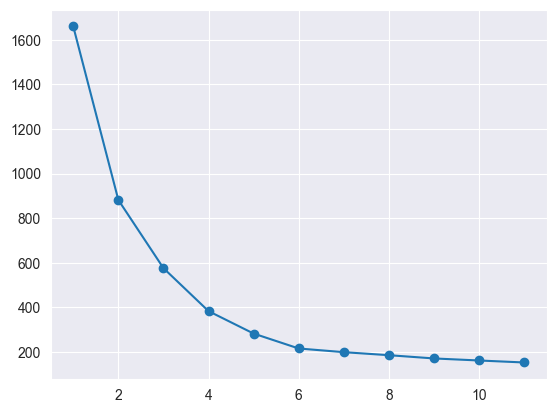

In [34]:
inertias = []
ks = range(1, 12)
for k in ks:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(pg_scaled)
    inertias.append(model.inertia_)
plt.plot(ks, inertias, '-o')
plt.show()

k=4 is a reasonable selection for the ideal number of clusters. We'll use k=4 for the KMeans algorithm parameter.

In [35]:
model = KMeans(n_clusters=4, n_init=10)
labels = model.fit_predict(pg_scaled)
pg_dummies['label'] = labels
print(pg_dummies.head())

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  MALE  \
0              39.1             18.7              181.0       3750.0     1   
1              39.5             17.4              186.0       3800.0     0   
2              40.3             18.0              195.0       3250.0     0   
3              36.7             19.3              193.0       3450.0     0   
4              39.3             20.6              190.0       3650.0     1   

   label  
0      2  
1      0  
2      0  
3      0  
4      2  


We've confirmed that the cluster labels are added to the original dataset. Now we can group our penguins together and identify their biostatistics.

In [36]:
stat_penguins = pg_dummies.groupby('label').mean()
print(stat_penguins)

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  MALE
label                                                                         
0             40.217757        17.611215         189.046729  3419.158879   0.0
1             49.473770        15.718033         221.540984  5484.836066   1.0
2             43.878302        19.111321         194.764151  4006.603774   1.0
3             45.563793        14.237931         212.706897  4679.741379   0.0


Finally, let's plot our penguin groups using Plotly. Since we have 5 features for each penguin, we will use PCA to reduce the dimensions to 2. Then we will calculate the centroids and the distance of each penguin to their group's centroid. Lastly, we'll create the plotly visual, include the centroids, and add a hover dialogue box displaying the distance to the centroid.

In [37]:
# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pg_pca = pca.fit_transform(pg_scaled)

# Calculate the centroids in the PCA space
centroids = pca.transform(model.cluster_centers_)

# Calculate the distance from each point to its cluster centroid
distances = np.linalg.norm(pg_pca - centroids[labels], axis=1)

# Create a DataFrame with the PCA results and additional details
pg_pca_df = pd.DataFrame(data=pg_pca, columns=['PC1', 'PC2'])
pg_pca_df['label'] = labels
pg_pca_df['distance_to_centroid'] = distances

# Plotting the clusters and centroids using Plotly
fig = px.scatter(pg_pca_df, x='PC1', y='PC2', color='label',
                 hover_data={'distance_to_centroid': True, 'PC1': False, 'PC2': False},
                 title='Penguin Clusters (PCA Reduced)',
                 labels={'label': 'Cluster', 'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'})

# Add centroids to the plot
for i, centroid in enumerate(centroids):
    fig.add_scatter(x=[centroid[0]], y=[centroid[1]], mode='markers', marker=dict(color='red', size=12, symbol='x'),
                    name=f'Centroid {i}')

# Show plot
fig.show()

## Results
We have 4 clusters of penguins. 2 of the clusters are female, and 2 of the clusters are male. The main difference between each sex's 2 groups is the body mass. Group A for each sex is significantly larger than group B. These larger penguins also had longer, thinner culmens and longer flippers. Based on the visual, the groupings appear accurate and logical. The centroids are distant from one another and their bubbles hover near the centroid. Clusters 0 and 2 have a larger variation than clusters 1 and 3, suggesting that there may be a reasoning for a 5th or 6th group.